In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Set seaborn style globally
sns.set(style="whitegrid", font_scale=1.1)


from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.stats import boxcox
from scipy.stats import ks_2samp

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    silhouette_score
)


In [35]:
# Διαβάζουμε το σύνολο δεδομένων εκπαίδευσης από το αρχείο train.csv και test.csv
train_df = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')

In [36]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.5 KB
None


In [37]:
# Αποθήκευση της στήλης 'id' από το σύνολο δεδομένων δοκιμής για υποβολή
test_ids = test_df['id']

# Ορισμός του στόχου (target) για την πρόβλεψη
target_variable = "rainfall"

# Επιλογή των αριθμητικών χαρακτηριστικών, εξαιρώντας τη στήλη του στόχου 'rainfall'
numerical_features = [column for column in train_df.columns if column != target_variable]

# Εκτύπωση πληροφοριών για τη στήλη στόχο και τα αριθμητικά χαρακτηριστικά
print("Στήλη Στόχος:", target_variable)
print("\nΑριθμητικά Χαρακτηριστικά:", numerical_features)


Στήλη Στόχος: rainfall

Αριθμητικά Χαρακτηριστικά: ['id', 'day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']


In [38]:
# Έλεγχος του μεγέθους του συνόλου δεδομένων και εμφάνιση των πρώτων γραμμών
print(f"Το σύνολο δεδομένων περιέχει {train_df.shape[0]} γραμμές και {train_df.shape[1]} στήλες.")
train_df.head()  # Εμφανίζει τις πρώτες 5 γραμμές του συνόλου δεδομένων


Το σύνολο δεδομένων περιέχει 2190 γραμμές και 13 στήλες.


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [39]:
# Λήψη στατιστικής περίληψης για το σύνολο δεδομένων
train_df.describe()  # Παρέχει στατιστικά για τις αριθμητικές στήλες του συνόλου δεδομένων


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,1094.500000,179.948402,1013.602146,26.365799,23.953059,22.170091,20.454566,82.036530,75.721918,3.744429,104.863151,21.804703,0.753425
std,632.342866,105.203592,5.655366,5.654330,5.222410,5.059120,5.288406,7.800654,18.026498,3.626327,80.002416,9.898659,0.431116
min,0.000000,1.000000,999.000000,10.400000,7.400000,4.000000,-0.300000,39.000000,2.000000,0.000000,10.000000,4.400000,0.000000
25%,547.250000,89.000000,1008.600000,21.300000,19.300000,17.700000,16.800000,77.000000,69.000000,0.400000,40.000000,14.125000,1.000000
50%,1094.500000,178.500000,1013.000000,27.800000,25.500000,23.850000,22.150000,82.000000,83.000000,2.400000,70.000000,20.500000,1.000000
75%,1641.750000,270.000000,1017.775000,31.200000,28.400000,26.400000,25.000000,88.000000,88.000000,6.800000,200.000000,27.900000,1.000000
max,2189.000000,365.000000,1034.600000,36.000000,31.500000,29.800000,26.700000,98.000000,100.000000,12.100000,300.000000,59.500000,1.000000


Παρέχει πληροφορίες όπως:

count: Ο αριθμός των μη κενών τιμών.

mean: Η μέση τιμή.

std: Η τυπική απόκλιση.

min: Η ελάχιστη τιμή.

25%: Το 25ο ποσοστημόριο (1ο τεταρτημόριο).

50%: Η διάμεσος (2ο τεταρτημόριο).

75%: Το 75ο ποσοστημόριο (3ο τεταρτημόριο).

max: Η μέγιστη τιμή.

In [40]:
# Προσδιορισμός των αριθμητικών στηλών
numerical_columns = [col for col in train_df.columns if train_df[col].dtype in ['int64', 'float64']]

# Υπολογισμός των στατιστικών περιλήψεων για κάθε χαρακτηριστικό
skew_values = train_df[numerical_columns].skew(numeric_only=True)
mean_values = train_df[numerical_columns].mean(numeric_only=True)
std_values = train_df[numerical_columns].std(numeric_only=True)

# Δημιουργία DataFrame για τα στατιστικά
stat_df = pd.DataFrame({
    'Feature': skew_values.index,
    'Mean': mean_values.round(3),
    'Std Dev': std_values.round(3),
    'Skewness': skew_values.round(3)
})

# Ταξινόμηση με βάση τη μέση τιμή σε απόλυτη τιμή
stat_df = stat_df.reindex(stat_df['Mean'].abs().sort_values(ascending=False).index).reset_index(drop=True)

# Συνάρτηση για χρωματισμό με βάση τα στατιστικά
def colorize(val, column_name):
    color = ''
    if column_name == 'Skewness' and abs(val) > 1:
        color = 'color: red; font-weight: bold'
    elif column_name == 'Std Dev' and val > stat_df['Std Dev'].median() + stat_df['Std Dev'].std():
        color = 'color: orange; font-weight: bold'
    elif column_name == 'Mean' and val > stat_df['Mean'].median() + stat_df['Mean'].std():
        color = 'color: blue; font-weight: bold'
    return color

# Δημιουργία στυλ για το DataFrame
styled_df = stat_df.style.applymap(lambda val: colorize(val, 'Mean'), subset=['Mean']) \
                         .applymap(lambda val: colorize(val, 'Std Dev'), subset=['Std Dev']) \
                         .applymap(lambda val: colorize(val, 'Skewness'), subset=['Skewness']) \
                         .set_table_styles([{'selector': 'th', 'props': [('background-color', '#afe1f0'), ('font-weight', 'bold')]}]) \
                         .set_properties(**{'background-color': 'white'})

# Εμφάνιση του DataFrame με το στυλ
styled_df


<ipython-input-40-b53c4e59ac4b>:32: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = stat_df.style.applymap(lambda val: colorize(val, 'Mean'), subset=['Mean']) \


,Feature,Mean,Std Dev,Skewness
0,id,1094.500000,632.343000,0.000000
1,pressure,1013.602000,5.655000,0.284000
2,day,179.948000,105.204000,0.031000
3,winddirection,104.863000,80.002000,0.708000
4,humidity,82.037000,7.801000,-0.562000
5,cloud,75.722000,18.026000,-1.339000
6,maxtemp,26.366000,5.654000,-0.491000
7,temparature,23.953000,5.222000,-0.557000
8,mintemp,22.170000,5.059000,-0.649000
9,windspeed,21.805000,9.899000,0.769000


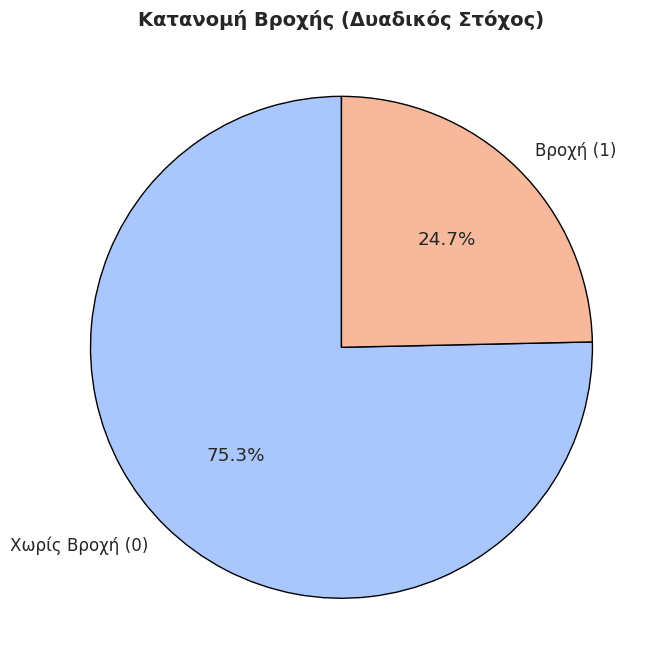

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ορισμός της στοχοθετημένης μεταβλητής
target_column = 'rainfall'

# Κατανομή της στοχοθετημένης μεταβλητής
target_counts = train_df[target_column].value_counts()
labels = ['Χωρίς Βροχή (0)', 'Βροχή (1)']
counts = target_counts.values
total = counts.sum()
ratios = [f'{(count / total) * 100:.1f}%' for count in counts]

# Δημιουργία γραφήματος πίτας
plt.figure(figsize=(7, 7))
plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=sns.color_palette("coolwarm", 2), startangle=90, wedgeprops={'edgecolor': 'black'})

# Προσθήκη τίτλου και εμφάνιση του γραφήματος
plt.title('Κατανομή Βροχής (Δυαδικός Στόχος)', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

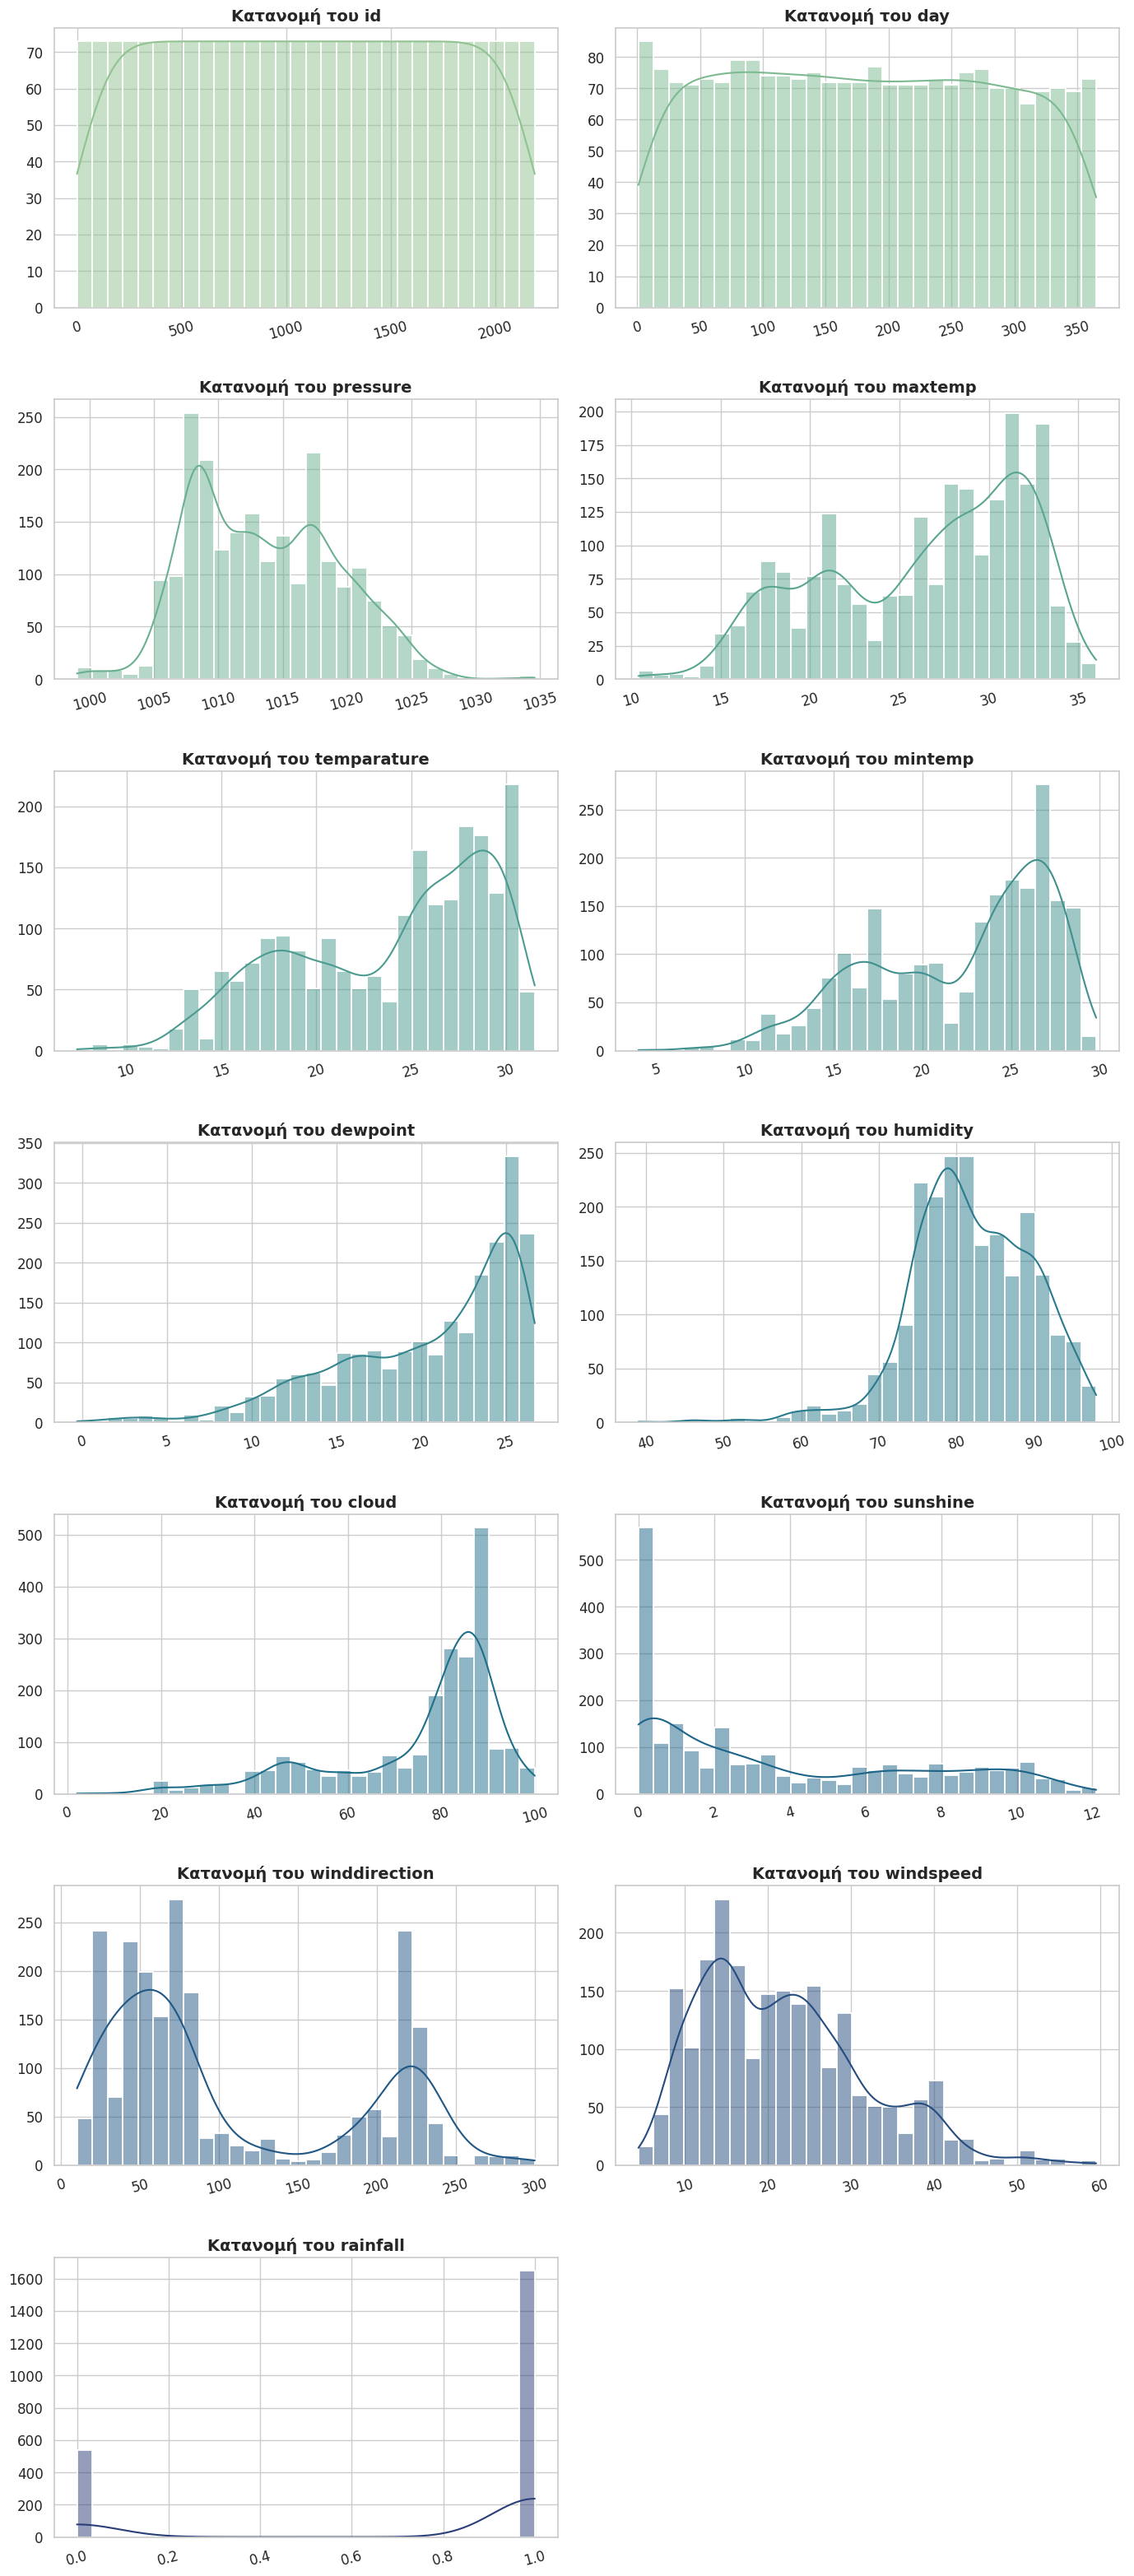

In [42]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Υπολογισμός των σειρών και στηλών για τα γραφήματα
num_vars = len(numerical_columns)
num_cols = 2  # 2 στήλες για καλύτερη αναγνωσιμότητα
num_rows = math.ceil(num_vars / num_cols)  # Υπολογισμός των σειρών δυναμικά

# Δημιουργία υποπλοκών
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, num_rows * 4.5))

# Εξομαλύνετε τον πίνακα axes για εύκολη πρόσβαση
axes = axes.ravel()

# Χρωματική παλέτα (φιλική για άτομα με χρωματική αχρωματοψία)
palette = sns.color_palette("crest", n_colors=num_vars)

# Σχεδίαση κάθε μεταβλητής
for i, var in enumerate(numerical_columns):
    sns.histplot(
        data=train_df,
        x=var,
        kde=True,
        color=palette[i],
        bins=30,
        edgecolor="white",
        linewidth=1.3,
        ax=axes[i]
    )
    axes[i].set_title(f"Κατανομή του {var}", fontsize=14, weight="bold")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].tick_params(axis='x', labelrotation=15)

# Αφαίρεση αχρησιμοποίητων αξόνων
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ρύθμιση διάταξης για καλύτερη εμφάνιση
plt.tight_layout(h_pad=2.5)
plt.show()


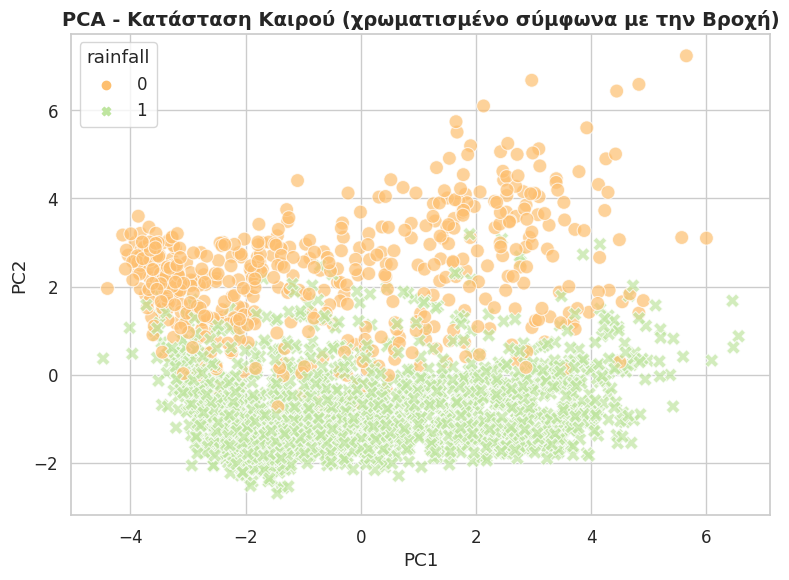

In [43]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Δημιουργία καθαρής αντιγραφής των δεδομένων για ανάλυση
df_eda = train_df.copy()

# Επιλογή των κατάλληλων στηλών (χωρίς τις στήλες 'id' και 'day')
cols_to_use = [col for col in numerical_columns if col not in ['id', 'day']]

# Καθαρισμένα δεδομένα για ανάλυση
X_eda = df_eda[cols_to_use]

# Κανονικοποίηση των μετεωρολογικών χαρακτηριστικών
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_eda)

# Δημιουργία του PCA με 2 συνιστώσες
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Εισαγωγή των αποτελεσμάτων PCA στη βάση δεδομένων
df_eda["PC1"] = X_pca[:, 0]
df_eda["PC2"] = X_pca[:, 1]

# Διαφορετικός τρόπος για την οπτικοποίηση (π.χ., χρησιμοποιώντας διαφορετική παλέτα ή κυκλική διάταξη)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_eda, x="PC1", y="PC2", hue="rainfall", style="rainfall", palette="Spectral", s=100, marker="o", alpha=0.7)

# Ρυθμίσεις για την εμφάνιση του γραφήματος
plt.title("PCA - Κατάσταση Καιρού (χρωματισμένο σύμφωνα με την Βροχή)", fontsize=14, fontweight='bold')
plt.grid(True)
plt.tight_layout()

# Εμφάνιση του διαγράμματος
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

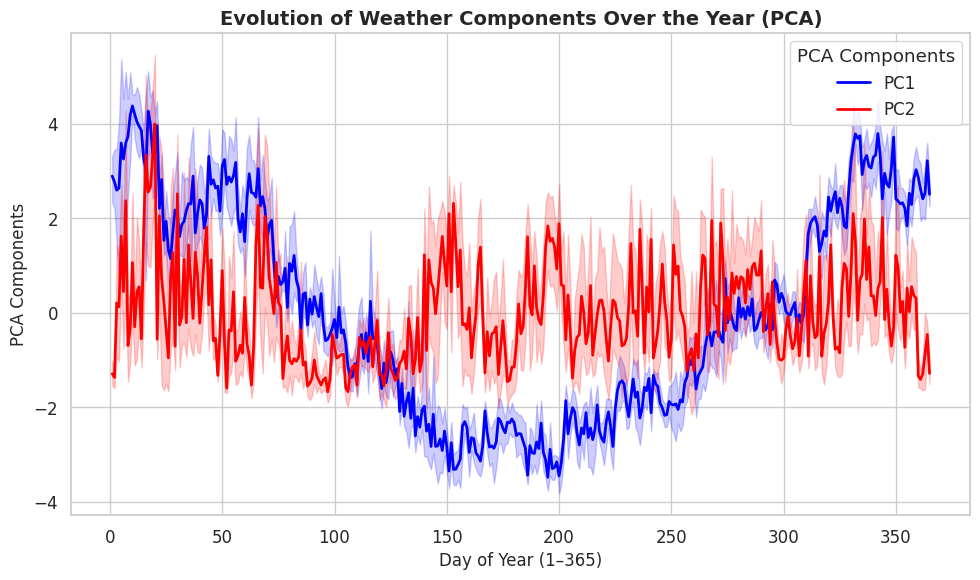

In [44]:
#  απεικόνιση της κατανομής των PCA components με γραμμές
plt.figure(figsize=(10, 6))

# Δημιουργία γραμμών για PC1 και PC2
sns.lineplot(data=df_eda, x="day", y="PC1", label="PC1", color="blue", linewidth=2)
sns.lineplot(data=df_eda, x="day", y="PC2", label="PC2", color="red", linewidth=2)

# Προσθήκη τίτλου και ετικετών
plt.title("Evolution of Weather Components Over the Year (PCA)", fontsize=14, weight='bold')
plt.xlabel("Day of Year (1–365)", fontsize=12)
plt.ylabel("PCA Components", fontsize=12)

# Εμφάνιση υπομνήματος και γραμμών πλέγματος
plt.legend(title="PCA Components", fontsize=12)
plt.grid(True)

# Ρύθμιση για καλύτερη εμφάνιση
plt.tight_layout()
plt.show()


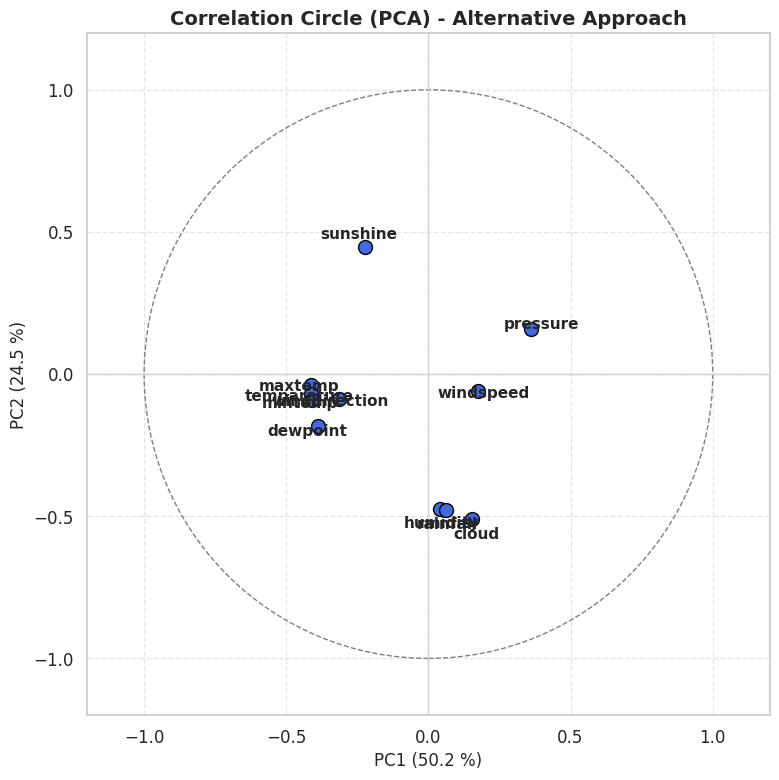

In [45]:
# Δημιουργία  διαγράμματος για το "Correlation Circle" 

# Ανάκτηση συνιστωσών PCA και εξηγούμενης διακύμανσης
components = pca.components_
explained_var = pca.explained_variance_ratio_
feature_names = cols_to_use

# Δημιουργία διαγράμματος
plt.figure(figsize=(8, 8))

# Εισαγωγή κύκλου μονάδας
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--', linewidth=1)
plt.gca().add_artist(circle)

# Σχεδίαση των συνιστωσών (Arrows) με διαφορετικά χρώματα
for i, var in enumerate(feature_names):
    x, y = components[0, i], components[1, i]

    # Αντιπροσωπεία του κάθε χαρακτηριστικού ως σημείο
    plt.scatter(x, y, color='royalblue', s=100, label=var, edgecolors='black')

    # Προσθήκη ετικετών δίπλα στα σημεία για να δείξουν τα χαρακτηριστικά
    plt.text(x * 1.1, y * 1.1, var, fontsize=11, ha='center', va='center', fontweight='bold')

# Ρυθμίσεις γραμμών και αξόνων
plt.axhline(0, color='lightgray', linewidth=1)
plt.axvline(0, color='lightgray', linewidth=1)

# Ρύθμιση τίτλων και αξόνων
plt.xlabel(f"PC1 ({explained_var[0]*100:.1f} %)", fontsize=12)
plt.ylabel(f"PC2 ({explained_var[1]*100:.1f} %)", fontsize=12)
plt.title("Correlation Circle (PCA) - Alternative Approach", fontsize=14, weight='bold')

# Ρυθμίσεις για όρια και εμφάνιση του διαγράμματος
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



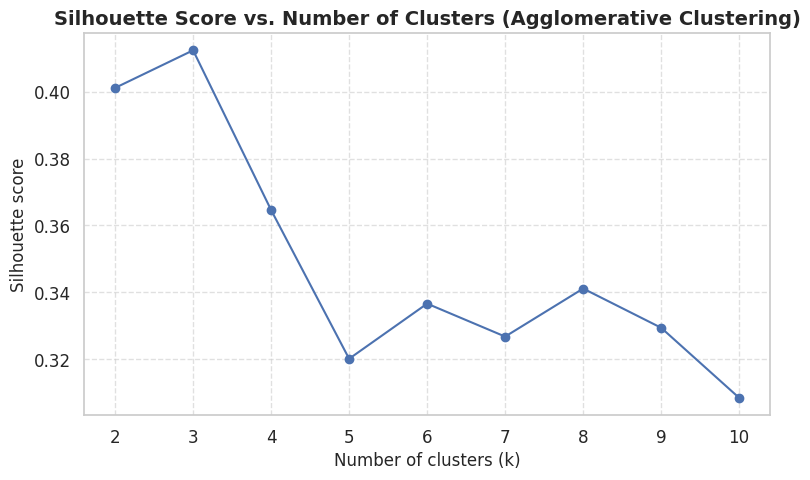

In [46]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Δεδομένα απο PCA
X_pca = df_eda[["PC1", "PC2"]].values

# Εύρος αριθμού clusters
k_values = range(2, 11)
silhouette_scores = []

# Υπολογισμός του silhouette score για διαφορετικό αριθμό clusters
for k in k_values:
    clustering = AgglomerativeClustering(n_clusters=k)
    labels = clustering.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    silhouette_scores.append(score)

#  silhouette σκορ
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', color='b')
plt.title("Silhouette Score vs. Number of Clusters (Agglomerative Clustering)", fontsize=14, weight='bold')
plt.xlabel("Number of clusters (k)", fontsize=12)
plt.ylabel("Silhouette score", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Silhouette Score: Αυτός ο δείκτης χρησιμοποιείται για να αξιολογήσει την ποιότητα των clusters. Έχει τιμές από -1 έως 1, με υψηλότερες τιμές να υποδεικνύουν πιο συνεκτικά clusters.

Agglomerative Clustering: Ο αλγόριθμος αυτός εκτελεί bottom-up προσέγγιση για να δημιουργήσει clusters, ξεκινώντας με κάθε δείγμα ως ξεχωριστό cluster και συνεχίζοντας με τη συγχώνευση των πλησιέστερων clusters

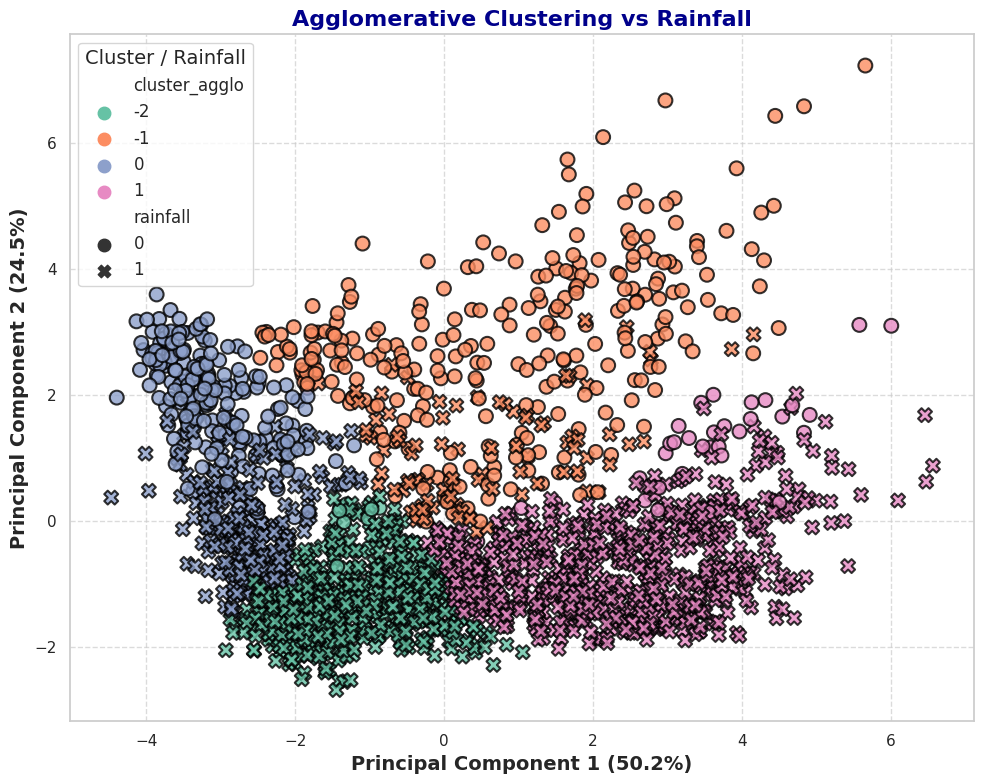

Agglomerative Clustering - Accuracy: 0.4274
Agglomerative Clustering - ROC AUC: 0.5522


In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.cluster import AgglomerativeClustering

# 1. Run Agglomerative Clustering (k=4)
agglo = AgglomerativeClustering(n_clusters=4)
clusters_agglo = agglo.fit_predict(X_pca)

# 2. True labels
y_true = df_eda[target_column].values
y_pred = clusters_agglo

# 3. Handle potential label inversion
acc1 = accuracy_score(y_true, y_pred)
acc2 = accuracy_score(y_true, 1 - y_pred)
if acc2 > acc1:
    y_pred = 1 - y_pred

# 4. Metrics
accuracy = accuracy_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

# 5. Add to df_eda
df_eda["cluster_agglo"] = y_pred

# 6. Plot PCA with color=cluster, marker=rainfall
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

# Scatterplot with customizations
sns.scatterplot(data=df_eda, x="PC1", y="PC2",
                hue="cluster_agglo", style=target_column,
                palette="Set2", alpha=0.8, s=100, edgecolor='black', linewidth=1.5)

# Customizing the title and labels
plt.title("Agglomerative Clustering vs Rainfall", fontsize=16, weight='bold', color='darkblue')
plt.xlabel(f"Principal Component 1 ({explained_var[0]*100:.1f}%)", fontsize=14, weight='bold')
plt.ylabel(f"Principal Component 2 ({explained_var[1]*100:.1f}%)", fontsize=14, weight='bold')

# Customize legend
plt.legend(title="Cluster / Rainfall", fontsize=12, title_fontsize=14, loc="upper left", markerscale=1.5)

# Adding gridlines and adjusting the layout
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# 8. Show plot
plt.show()

# 9. Print metrics
print(f"Agglomerative Clustering - Accuracy: {accuracy:.4f}")
print(f"Agglomerative Clustering - ROC AUC: {auc:.4f}")


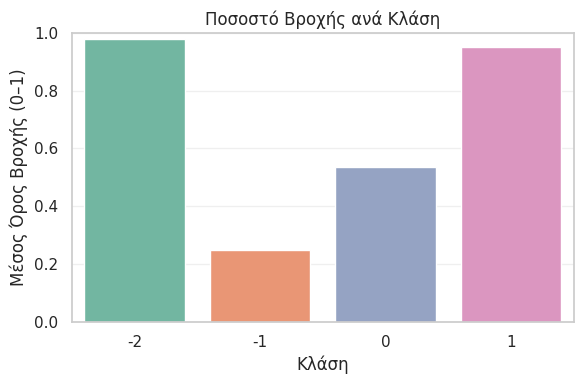

In [48]:
# Εξασφάλιση ότι οι στήλες 'cluster_agglo' και 'rainfall' υπάρχουν στο DataFrame
df_clustered = df_eda.copy()

# Μέσος όρος βροχής ανά κλάση
plt.figure(figsize=(6, 4))
rain_perc = df_clustered.groupby("cluster_agglo")[target_column].mean()

# Δημιουργία ράβδων για την ποσοστιαία κατανομή βροχής
sns.barplot(x=rain_perc.index, y=rain_perc.values, palette="Set2")

# Ρυθμίσεις γραφήματος
plt.title("Ποσοστό Βροχής ανά Κλάση")
plt.ylabel("Μέσος Όρος Βροχής (0–1)")
plt.xlabel("Κλάση")
plt.ylim(0, 1)

# Προσθήκη γραμμών πλέγματος στον άξονα y
plt.grid(axis="y", alpha=0.3)

# Ρύθμιση εμφάνισης
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

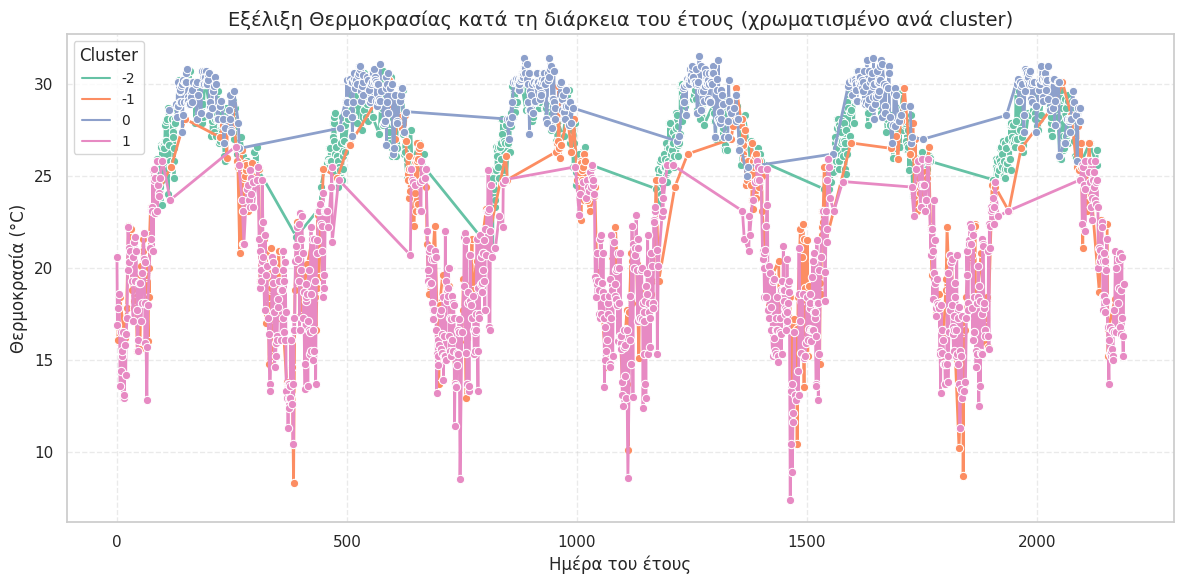

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

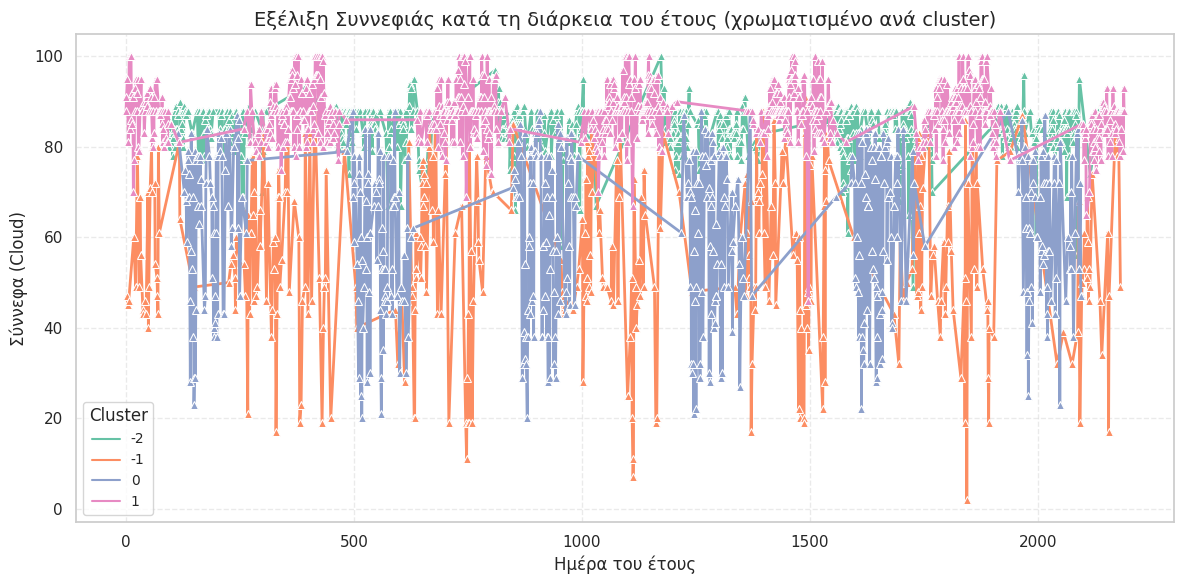

In [49]:
# Δημιουργία νέου DataFrame για το γράφημα
df_plot = df_clustered.copy()

# Plot: Θερμοκρασία σε σχέση με την ημέρα του έτους
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot,
             x="id",  # Ημέρα του έτους
             y="temparature",  # Θερμοκρασία
             hue="cluster_agglo",  # Χρώμα με βάση το cluster
             palette="Set2",  # Χρωματική παλέτα
             lw=2,  # Πάχος γραμμής
             marker="o",  # Σημείο για κάθε δεδομένο
             markersize=6)  # Μέγεθος σημείων

plt.title("Εξέλιξη Θερμοκρασίας κατά τη διάρκεια του έτους (χρωματισμένο ανά cluster)", fontsize=14)
plt.xlabel("Ημέρα του έτους", fontsize=12)
plt.ylabel("Θερμοκρασία (°C)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Cluster", fontsize=10)
plt.tight_layout()
plt.show()

# Plot: Υγρασία σε σχέση με την ημέρα του έτους (Cloud)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot,
             x="id",  # Ημέρα του έτους
             y="cloud",  # Σύννεφα (υγρασία)
             hue="cluster_agglo",  # Χρωματισμός με βάση το cluster
             palette="Set2",  # Χρωματική παλέτα
             lw=2,  # Πάχος γραμμής
             marker="^",  # Τρίγωνο για σημεία
             markersize=6)  # Μέγεθος σημείων

plt.title("Εξέλιξη Συννεφιάς κατά τη διάρκεια του έτους (χρωματισμένο ανά cluster)", fontsize=14)
plt.xlabel("Ημέρα του έτους", fontsize=12)
plt.ylabel("Σύννεφα (Cloud)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Cluster", fontsize=10)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


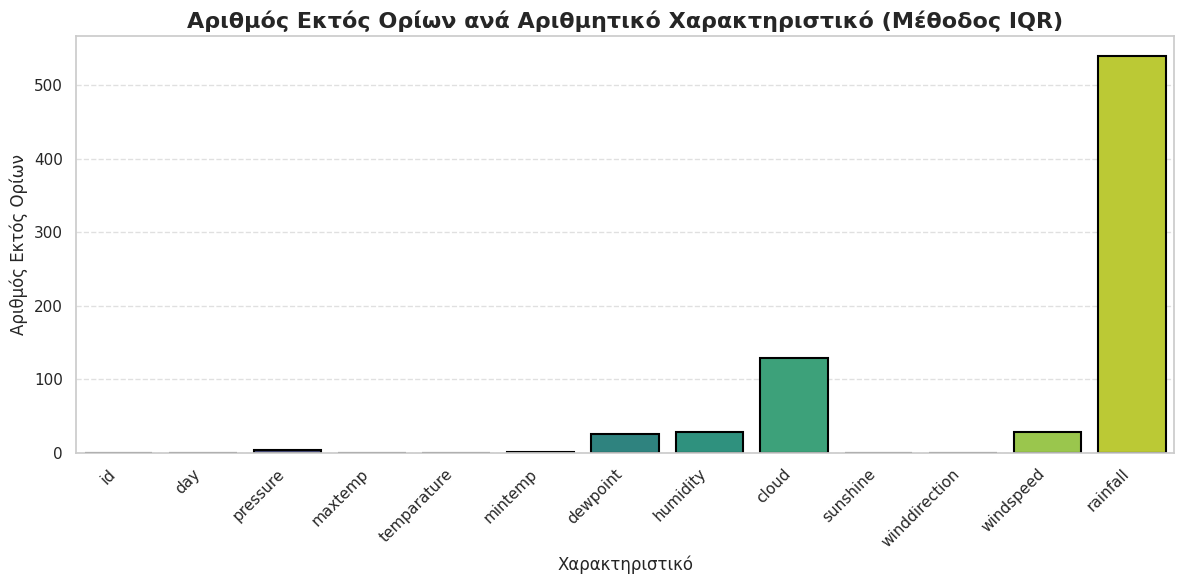

In [50]:
# Συνάρτηση ανίχνευσης εκτός ορίων χρησιμοποιώντας μέθοδο IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Μέτρηση των εκτός ορίων για κάθε αριθμητικό χαρακτηριστικό
outlier_counts = {var: len(detect_outliers_iqr(train_df, var)) for var in numerical_columns}

# Δημιουργία barplot με βελτιώσεις στο σχέδιο
plt.figure(figsize=(12, 6))

# Χρησιμοποιούμε πιο ωραία χρωματική παλέτα (π.χ. 'viridis' για πιο ευχάριστο χρωματικό φάσμα)
sns.barplot(x=list(outlier_counts.keys()), 
            y=list(outlier_counts.values()), 
            palette="viridis")

# Προσθήκη τίτλου και ετικετών αξόνων με γραμματοσειρές και στυλ
plt.title("Αριθμός Εκτός Ορίων ανά Αριθμητικό Χαρακτηριστικό (Μέθοδος IQR)", fontsize=16, weight='bold')
plt.xlabel("Χαρακτηριστικό", fontsize=12)
plt.ylabel("Αριθμός Εκτός Ορίων", fontsize=12)

# Περιστροφή των labels στον άξονα x για καλύτερη ανάγνωση
plt.xticks(rotation=45, ha='right', fontsize=11)

# Προσθήκη σκιών στις ράβδους για πιο εντυπωσιακό αποτέλεσμα
for bar in plt.gca().patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(1.5)

# Προσθήκη πλέγματος στον άξονα y για καλύτερη καθοδήγηση
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Βελτίωση της διάταξης
plt.tight_layout()

# Εμφάνιση του γραφήματος
plt.show()


Estimated Contamination Rate: 0.0266


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


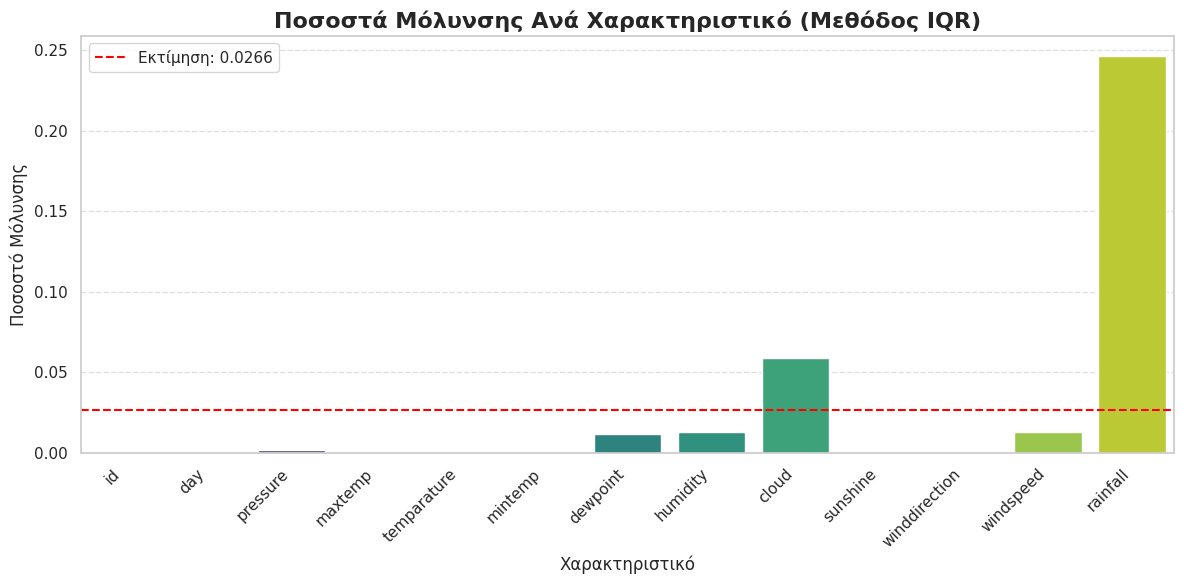

In [51]:
# Υπολογισμός εκτίμησης ποσοστού μόλυνσης
estimated_contamination = np.mean([
    len(detect_outliers_iqr(train_df, col)) / len(train_df) for col in numerical_columns
])

# Εκτύπωση εκτιμώμενου ποσοστού μόλυνσης
print(f"Estimated Contamination Rate: {estimated_contamination:.4f}")

# Δημιουργία γραφήματος για τα ποσοστά μόλυνσης ανά χαρακτηριστικό
outlier_percentages = [
    len(detect_outliers_iqr(train_df, col)) / len(train_df) for col in numerical_columns
]

# Δημιουργία barplot για τα ποσοστά μόλυνσης
plt.figure(figsize=(12, 6))
sns.barplot(x=numerical_columns, y=outlier_percentages, palette="viridis")

# Προσθήκη τίτλων και ετικετών
plt.title("Ποσοστά Μόλυνσης Ανά Χαρακτηριστικό (Μεθόδος IQR)", fontsize=16, weight='bold')
plt.xlabel("Χαρακτηριστικό", fontsize=12)
plt.ylabel("Ποσοστό Μόλυνσης", fontsize=12)

# Περιστροφή των ετικετών για καλύτερη ανάγνωση
plt.xticks(rotation=45, ha='right', fontsize=11)

# Προσθήκη πλέγματος στον άξονα y για καλύτερη καθοδήγηση
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Προσθήκη συνολικής εκτίμησης ποσοστού μόλυνσης στο γράφημα
plt.axhline(estimated_contamination, color='red', linestyle='--', label=f"Εκτίμηση: {estimated_contamination:.4f}")
plt.legend()

# Βελτίωση της διάταξης
plt.tight_layout()

# Εμφάνιση του γραφήματος
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


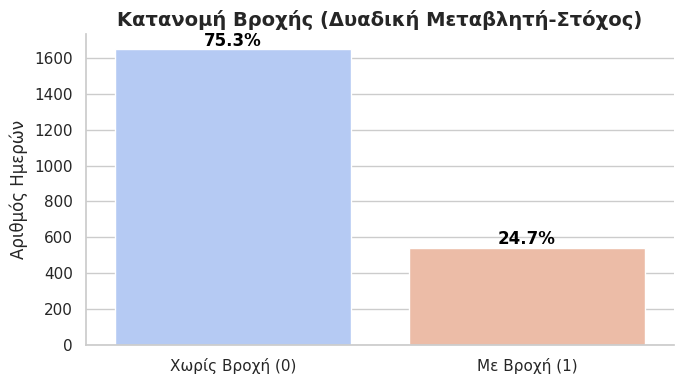

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Καταμέτρηση της κατανομής της μεταβλητής-στόχου
target_counts = train_df[target_column].value_counts()

# Ορισμός των ετικετών για τις κατηγορίες
labels = ['Χωρίς Βροχή (0)', 'Με Βροχή (1)']

# Αριθμός ημερών για κάθε κατηγορία
counts = target_counts.values

# Σύνολο όλων των καταγραφών
total = counts.sum()

# Υπολογισμός των ποσοστών για κάθε κατηγορία
ratios = [f'{(count / total) * 100:.1f}%' for count in counts]

# Δημιουργία του γραφήματος
plt.figure(figsize=(7, 4))

# Δημιουργία bar plot με την παλέτα "coolwarm"
bars = sns.barplot(x=labels, y=counts, palette="coolwarm")

# Προσθήκη ποσοστών πάνω από κάθε μπάρες
for bar, ratio in zip(bars.patches, ratios):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 20,  # Τοποθέτηση του ποσοστού πάνω από τη μπάρα
             ratio, ha='center', fontsize=12, fontweight='bold', color='black')

# Προσθήκη τίτλου και μορφοποίηση
plt.title('Κατανομή Βροχής (Δυαδική Μεταβλητή-Στόχος)', fontsize=14, weight='bold')
plt.ylabel('Αριθμός Ημερών', fontsize=12)
plt.xlabel('', fontsize=12)

# Καλύτερη εμφάνιση χωρίς περιττές γραμμές
sns.despine()

# Σφιχτή διάταξη για να μην χάνονται οι ετικέτες
plt.tight_layout()

# Εμφάνιση του γραφήματος
plt.show()


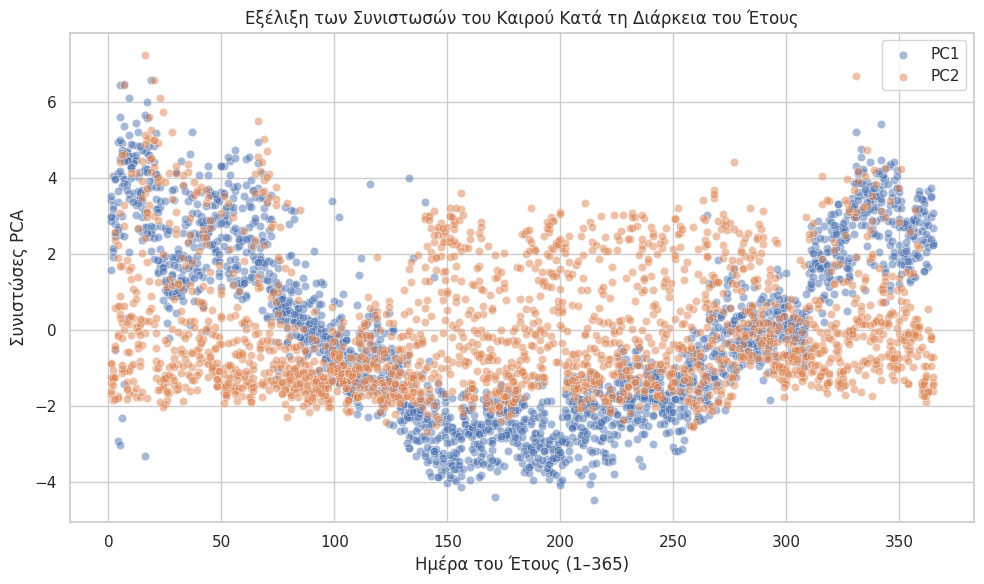

In [63]:
# Κατανομή των συνιστωσών PCA κατά τη διάρκεια του έτους
plt.figure(figsize=(10, 6))

# Δημιουργία scatter plot για την πρώτη συνιστώσα PCA (PC1)
sns.scatterplot(data=df_eda, x="day", y="PC1", alpha=0.5, label="PC1")

# Δημιουργία scatter plot για τη δεύτερη συνιστώσα PCA (PC2)
sns.scatterplot(data=df_eda, x="day", y="PC2", alpha=0.5, label="PC2")

# Προσθήκη τίτλου στο γράφημα
plt.title("Εξέλιξη των Συνιστωσών του Καιρού Κατά τη Διάρκεια του Έτους")

# Ετικέτες στους άξονες
plt.xlabel("Ημέρα του Έτους (1–365)")
plt.ylabel("Συνιστώσες PCA")

# Προσθήκη υπόμνημα για τις δύο συνιστώσες
plt.legend()

# Προσθήκη πλέγματος για καλύτερη αναγνωσιμότητα
plt.grid(True)

# Βελτιστοποίηση διάταξης για να μην χαθούν οι ετικέτες
plt.tight_layout()

# Εμφάνιση του γραφήματος
plt.show()


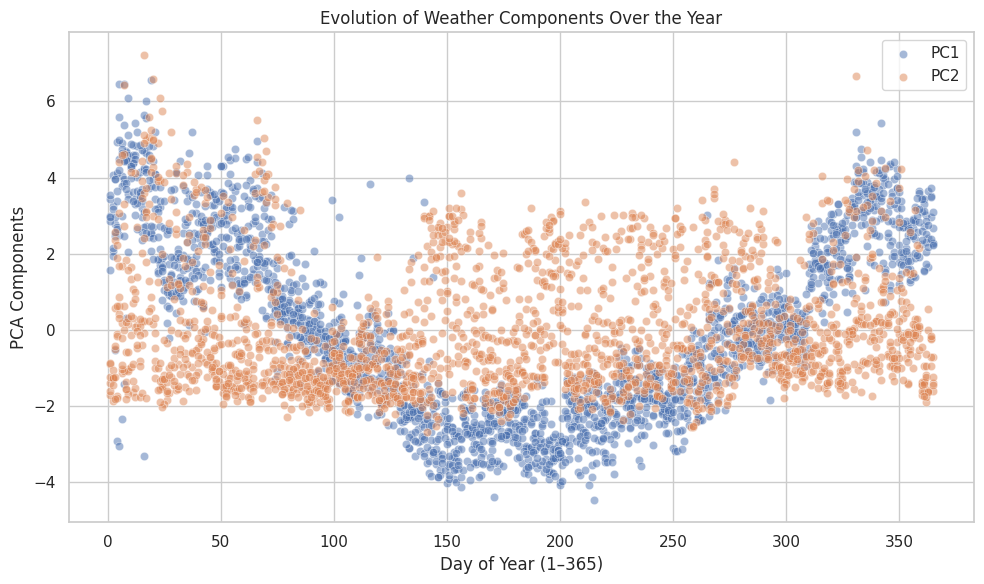

In [61]:
# Distribution of PCA components over the year
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_eda, x="day", y="PC1", alpha=0.5, label="PC1")
sns.scatterplot(data=df_eda, x="day", y="PC2", alpha=0.5, label="PC2")
plt.title("Evolution of Weather Components Over the Year")
plt.xlabel("Day of Year (1–365)")
plt.ylabel("PCA Components")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [69]:
import os

# Έλεγχος για την ύπαρξη του αρχείου
file_path = "/kaggle/input/0-96245-lda-lgs-ensemble-for-rainfall-pred/submission.csv"
if os.path.exists(file_path):
    print(f"Το αρχείο βρέθηκε στο {file_path}")
else:
    print(f"Το αρχείο δεν βρέθηκε στο {file_path}")


Το αρχείο δεν βρέθηκε στο /kaggle/input/0-96245-lda-lgs-ensemble-for-rainfall-pred/submission.csv


In [79]:
import pandas as pd
from scipy.stats import rankdata
from xgboost import XGBClassifier  # Αν χρησιμοποιείς XGBoost

# Διαβάζουμε το αρχείο του δείγματος υποβολής
sub = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")

# Αντικατάστησε με το δικό σου εκπαιδευμένο μοντέλο και δεδομένα
# Φόρτωση των δεδομένων του τεστ (π.χ., X_test)
# X_test = ... # Εδώ βάλε τα δεδομένα του τεστ

# Δημιουργία του μοντέλου (εάν δεν έχεις ήδη εκπαιδευμένο μοντέλο)
# Μπορείς να φορτώσεις το μοντέλο σου εάν έχεις αποθηκεύσει το μοντέλο σου π.χ. με joblib ή το μοντέλο από XGBoost
model = XGBClassifier()
# model.load_model("xgboost_model.json")  # Αν έχεις το μοντέλο αποθηκευμένο

# Αν το μοντέλο έχει εκπαιδευτεί, προχώρησε με τις προβλέψεις
# pred_xgb = model.predict_proba(X_test)[:, 1]  # Εδώ παίρνουμε τις προβλέψεις για την κατηγορία "Rain"

# Αν δεν έχεις το μοντέλο και απλώς θέλεις να δεις την εφαρμογή του υπολογισμού:
# Θα χρησιμοποιήσουμε ενδεικτικά προβλέψεις για να προχωρήσουμε με τη διαδικασία.

# Για το παράδειγμα, ας δημιουργήσουμε ψευδείς προβλέψεις (πρέπει να τις αντικαταστήσεις με το δικό σου μοντέλο):
import numpy as np
pred_xgb = np.random.rand(len(sub))  # Αυτό είναι ένα παράδειγμα, αντικατάστησέ το με τις πραγματικές προβλέψεις

# Σχηματίζουμε την τελική τιμή χρησιμοποιώντας τις προβλέψεις του μοντέλου
sub.rainfall = rankdata(pred_xgb) / len(sub)

# Εφαρμόζουμε συνθήκες για να κωδικοποιήσουμε τις προβλέψεις σε 0 ή 1
sub['rainfall'] = sub['rainfall'].apply(lambda x: 1 if x > 0.95 else 0 if x < 0.05 else x)

# Αποθηκεύουμε το τελικό αρχείο υποβολής
sub.to_csv("submission_final.csv", index=False)

# Εκτυπώνουμε τις πρώτες γραμμές του DataFrame για έλεγχο
print(sub.head())


     id  rainfall
0  2190  0.068493
1  2191  0.341096
2  2192  0.613699
3  2193  0.056164
4  2194  0.863014


In [82]:
# Αποθηκεύουμε το τελικό αρχείο υποβολής
sub.to_csv("submission_final.csv", index=False)

In [85]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score,  GridSearchCV
from sklearn.metrics import roc_auc_score
from scipy.stats import uniform, randint
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans

from warnings import filterwarnings
filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


In [86]:
train = pd.read_csv("/kaggle/input/playground-series-s5e3/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv")
train.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [87]:
test.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


In [88]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2190.0,1094.500000,632.342866,0.0,547.250,1094.50,1641.750,2189.0
day,2190.0,179.948402,105.203592,1.0,89.000,178.50,270.000,365.0
pressure,2190.0,1013.602146,5.655366,999.0,1008.600,1013.00,1017.775,1034.6
maxtemp,2190.0,26.365799,5.654330,10.4,21.300,27.80,31.200,36.0
temparature,2190.0,23.953059,5.222410,7.4,19.300,25.50,28.400,31.5
mintemp,2190.0,22.170091,5.059120,4.0,17.700,23.85,26.400,29.8
dewpoint,2190.0,20.454566,5.288406,-0.3,16.800,22.15,25.000,26.7
humidity,2190.0,82.036530,7.800654,39.0,77.000,82.00,88.000,98.0
cloud,2190.0,75.721918,18.026498,2.0,69.000,83.00,88.000,100.0
sunshine,2190.0,3.744429,3.626327,0.0,0.400,2.40,6.800,12.1


In [89]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,730.0,2554.500000,210.877136,2190.0,2372.250,2554.50,2736.750,2919.0
day,730.0,183.000000,105.438271,1.0,92.000,183.00,274.000,365.0
pressure,730.0,1013.503014,5.505871,1000.0,1008.725,1012.70,1017.600,1032.2
maxtemp,730.0,26.372466,5.672521,7.4,21.600,27.80,31.000,35.8
temparature,730.0,23.963288,5.278098,5.9,19.825,25.65,28.375,31.8
mintemp,730.0,22.110274,5.170744,4.2,17.825,23.90,26.400,29.1
dewpoint,730.0,20.460137,5.391169,-0.0,16.800,22.30,25.000,26.7
humidity,730.0,82.669863,7.818714,39.0,77.250,82.00,89.000,98.0
cloud,730.0,76.360274,17.934121,0.0,69.000,83.00,88.000,100.0
sunshine,730.0,3.664384,3.639272,0.0,0.325,2.20,6.675,11.8


In [90]:
train.isnull().sum()

id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64

In [91]:
test.isnull().sum()

id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    1
windspeed        0
dtype: int64

In [92]:
train["rainfall"].value_counts()

rainfall
1    1650
0     540
Name: count, dtype: int64

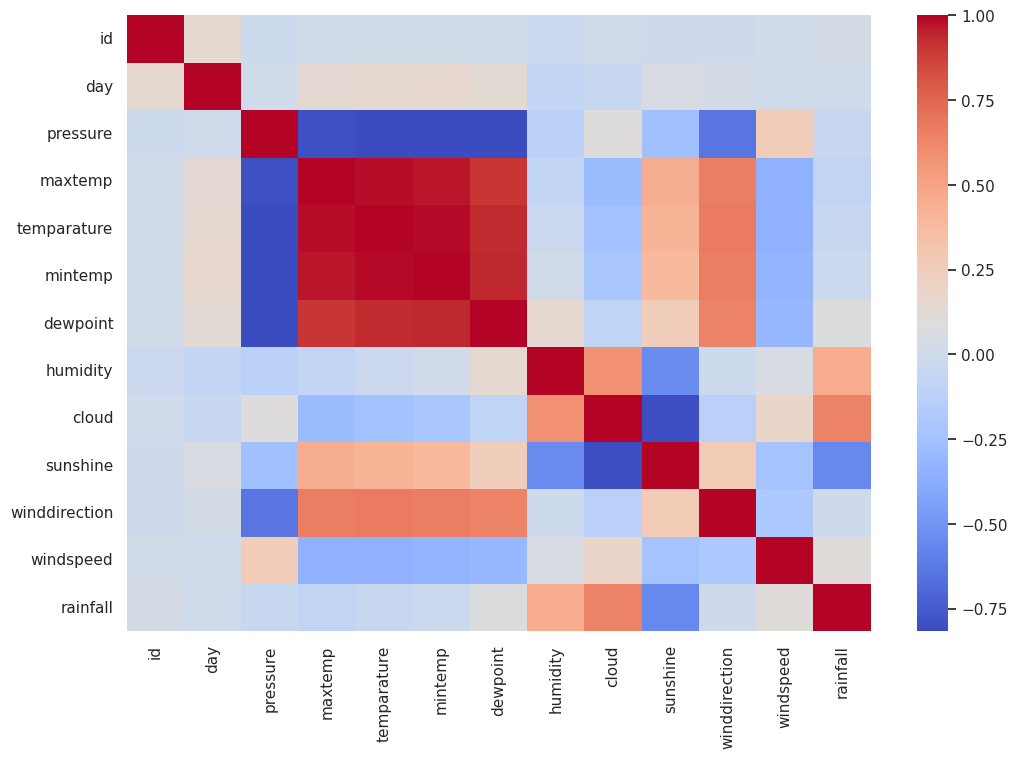

In [93]:
corr = train.corr()
plt.figure(figsize =(12,8))
sns.heatmap(corr,cmap ="coolwarm")
plt.show()

In [94]:
def get_season(day):
    if 80 <= day <= 171:
        return "spring"
    elif 172 <= day <= 263:
        return "summer"
    elif 264 <= day <= 354:
        return "fall"
    else:
        return "winter"
        
train["season"] = train["day"].apply(get_season)
test["season"] = test["day"].apply(get_season)

train["temp_range"] = train["maxtemp"] - train["mintemp"]
test["temp_range"] = test["maxtemp"] - test["mintemp"]

train["dew_humidity_ratio"] = train["dewpoint"] / (train["humidity"] + 1e-5)
test["dew_humidity_ratio"] = test["dewpoint"] / (test["humidity"] + 1e-5)

train["temp_dew_diff"] = train["temparature"] - train["dewpoint"]
test["temp_dew_diff"] = test["temparature"] - test["dewpoint"]

train["cloud_sun_ratio"] = train["cloud"] / (train["sunshine"] + 1e-5)
test["cloud_sun_ratio"] = test["cloud"] / (test["sunshine"] + 1e-5)

train["low_sun"] = (train["sunshine"] < 1).astype(int)
test["low_sun"] = (test["sunshine"] < 1).astype(int)

train["cloud_humidity"] = train["humidity"] * train["cloud"]
test["cloud_humidity"] = test["humidity"] * test["cloud"]

train["temp_humidity"] = train["humidity"] * train["temp_dew_diff"]
test["temp_humidity"] = test["humidity"] * test["temp_dew_diff"]

season_map = {"winter": 0, "spring": 1, "summer": 2, "fall": 3}

train["season_num"] = train["season"].map(season_map)
test["season_num"] = test["season"].map(season_map)

train["cloud_sun_season"] = train["cloud_sun_ratio"] * train["season_num"]
test["cloud_sun_season"] = test["cloud_sun_ratio"] * test["season_num"]

train["cloud_sun_intersect"] = train["cloud"] * train["sunshine"]
test["cloud_sun_intersect"] = test["cloud"] * test["sunshine"]

train["cloud_humidity_intersect"] = train["cloud"] * train["humidity"]
test["cloud_humidity_intersect"] = test["cloud"] * test["humidity"]

train["cloud_sun_intersect"] = train["cloud"] / (train["sunshine"] + 1e-3)
test["cloud_sun_intersect"] = test["cloud"] / (test["sunshine"] + 1e-3)

train["humidity_dewpoint_intersect"] = train["humidity"] * train["dewpoint"]
test["humidity_dewpoint_intersect"] = test["humidity"] * test["dewpoint"]

train["sun_wind_intersect"] = train["sunshine"] / (train["windspeed"] + 1e-3)
test["sun_wind_intersect"] = test["sunshine"] / (test["windspeed"] + 1e-3)

train["cloud_low_sun_intersect"] = train["cloud"] * train["low_sun"]
test["cloud_low_sun_intersect"] = test["cloud"] * test["low_sun"]

bool_cols = train.select_dtypes(include='bool').columns

for col in bool_cols:
    train[col] = train[col].astype(int)
    test[col] = test[col].astype(int)
    
train = train.drop(["season"],axis = 1)
test = test.drop(["season"], axis = 1)
test["winddirection"].fillna(test["winddirection"].mean(), inplace=True)
X = train.drop(["id", "rainfall"], axis=1)
y = train["rainfall"]

X_test = test.drop(["id"],axis = 1)

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

In [95]:
NB_model = GaussianNB().fit(X_scaled,y)
scores = cross_val_score(NB_model, X_scaled, y, cv=5, scoring='roc_auc')
print(f"Mean AUC: {scores.mean():.4f}")

Mean AUC: 0.8801


In [96]:
y_test_pred = NB_model.predict_proba(X_test_scaled)[:,1]
submission = pd.DataFrame({
    "id": test["id"],
    "rainfall": y_test_pred
})

submission.to_csv("submission_naivebayes.csv", index=False)

In [97]:
l1_model = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
scores = cross_val_score(l1_model, X_scaled, y, cv=5, scoring='roc_auc')
print(f"Mean AUC: {scores.mean():.4f}")

Mean AUC: 0.8904


In [98]:
l1_model.fit(X_scaled , y)
y_test_pred = l1_model.predict_proba(X_test_scaled)[:,1]
submission = pd.DataFrame({
    "id": test["id"],
    "rainfall": y_test_pred
})

submission.to_csv("submission_logreg.csv", index=False)

In [99]:
lr = LogisticRegression(solver="liblinear", random_state=42)

param_grid = {
    "penalty": ["l1", "l2"],
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "class_weight": [None, "balanced"],
    "solver" : ["liblinear"]
}

grid = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=10,
    n_jobs=-1,
    verbose=0
)

grid.fit(X_scaled, y)

GridSearchCV(cv=10,
             estimator=LogisticRegression(random_state=42, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': [None, 'balanced'],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='roc_auc')

In [100]:
grid.best_params_

{'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}

In [101]:
final_lr = LogisticRegression(solver="liblinear",penalty= "l2",class_weight = None,C=0.01, max_iter = 1000, random_state=42)
scores = cross_val_score(final_lr, X_scaled, y, cv=5, scoring='roc_auc')
print(f"Mean AUC: {scores.mean():.4f}")
final_lr.fit(X_scaled,y)

Mean AUC: 0.8932


LogisticRegression(C=0.01, max_iter=1000, random_state=42, solver='liblinear')

In [102]:
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_scaled ,y)
y_test_pred_xgb = model.predict_proba(X_test_scaled)[:,1]
submission_xgb = pd.DataFrame({
    "id": test["id"],
    "rainfall": y_test_pred_xgb
})
submission_xgb.to_csv("submission_xgb.csv", index=False)

In [103]:
xgb_tuned_model = XGBClassifier(
    n_estimators = 200,
    colsample_bytree = 0.8,
    gamma = 1,
    learning_rate =0.05,
    max_depth = 5,
    reg_alpha = 0.1,
    reg_lambda = 1,
    subsample = 1,
    random_state = 42
)
xgb_tuned_model.fit(X_scaled, y)
y_test_pred_xgb = xgb_tuned_model.predict_proba(X_test_scaled)[:, 1]
submission_xgb_final = pd.DataFrame({
    "id": test["id"],
    "rainfall": y_test_pred_xgb
})
submission_xgb_final.to_csv("submission_xgb_final_model.csv", index=False)
scores = cross_val_score(xgb_tuned_model, X_scaled, y, cv=5, scoring='roc_auc')
print(f"Mean AUC: {scores.mean():.4f}")

Mean AUC: 0.8861


In [104]:
svc_model = SVC(C = 1,gamma = 0.001,kernel = "rbf",probability= True)
scores = cross_val_score(svc_model, X_scaled, y, cv=5, scoring='roc_auc')
print(f"Mean AUC: {scores.mean():.4f}")
svc_model.fit(X_scaled, y)

Mean AUC: 0.8942


SVC(C=1, gamma=0.001, probability=True)

In [105]:
y_test_pred = svc_model.predict_proba(X_test_scaled)[:, 1]

submission_lr = pd.DataFrame({
    "id": test["id"],
    "rainfall": y_test_pred
})
submission_lr.to_csv("submission_svc_final.csv", index=False)

In [106]:
rf_model = RandomForestClassifier(n_estimators = 300,max_depth = 10,max_features = "sqrt",min_samples_leaf=4,min_samples_split=2)
scores = cross_val_score(rf_model, X_scaled, y, cv=5, scoring='roc_auc')
print(f"Mean AUC: {scores.mean():.4f}")
rf_model.fit(X_scaled, y)

Mean AUC: 0.8886


RandomForestClassifier(max_depth=10, min_samples_leaf=4, n_estimators=300)

In [107]:
y_test_pred = rf_model.predict_proba(X_test_scaled)[:, 1]

submission_cat = pd.DataFrame({
    "id": test["id"],
    "rainfall": y_test_pred
})

submission_cat.to_csv("submission_randomF.csv", index=False)

In [108]:
mlpc = MLPClassifier(activation ='relu',alpha= 0.01,hidden_layer_sizes= (3, 5), solver = "adam")
scores = cross_val_score(mlpc, X_scaled, y, cv=5, scoring='roc_auc')
print(f"Mean AUC: {scores.mean():.4f}")
mlpc.fit(X_scaled, y)

Mean AUC: 0.8836


MLPClassifier(alpha=0.01, hidden_layer_sizes=(3, 5))

In [109]:
y_test_pred = mlpc.predict_proba(X_test_scaled)[:, 1]

submission_cat = pd.DataFrame({
    "id": test["id"],
    "rainfall": y_test_pred
})

submission_cat.to_csv("submission_mlpcs.csv", index=False)

In [110]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled) 
X_clustered = X_scaled.copy()
X_clustered = pd.DataFrame(X_scaled)
X_clustered["Cluster"] = clusters   
mlpc = MLPClassifier(hidden_layer_sizes=(3, 5), activation='relu', solver='adam', alpha=0.01, max_iter=1000, random_state=42)
mlpc.fit(X_clustered.values, y)

MLPClassifier(alpha=0.01, hidden_layer_sizes=(3, 5), max_iter=1000,
              random_state=42)

In [111]:
scores = cross_val_score(mlpc, X_scaled, y, cv=5, scoring='roc_auc')
print(f"Mean AUC: {scores.mean():.4f}")

Mean AUC: 0.8863


In [112]:
test_clusters = kmeans.predict(X_test_scaled)
X_test_clustered = pd.DataFrame(X_test_scaled)
X_test_clustered["Cluster"] = test_clusters
y_vote_pred = mlpc.predict_proba(X_test_clustered.values)[:, 1]
submission_vote = pd.DataFrame({
    "id": test["id"],
    "rainfall": y_vote_pred
})

submission_vote.to_csv("submission_ann_kmeans.csv", index=False)